## Fig. 3 panels C, D: cluster connectivity and Jaccard coefficient

In [1]:
import sys
from collections import Counter
from datetime import datetime
from itertools import combinations
from pathlib import Path
import anndata as ad
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np

script_path = Path.cwd().parent.parent.parent / "script"
sys.path.append(str(script_path))
from utils.cluster_connections import *
from utils.Jaccard_coefficient import *
from utils.knn import *

output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

c:\Users\duo.peng\Documents\Organelle_IP_figures\notebooks\Fig3\panels_C_D


### load k-NN graph and annotations

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
adata_path = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"adata_kNN_{timestamp}.h5ad"

try:
    adata = ad.read_h5ad(adata_path)
except FileNotFoundError:
    print(f"File {adata_path} not found.\nPlease run umap analysis first (fig2 panel C) or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the file at {adata_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# check data
print(adata)  # 8541 x 61 for reference dataset, and 8017 x 28 for remodeling data

AnnData object with n_obs × n_vars = 8541 × 61
    obs: 'Protein IDs', 'Majority protein IDs', 'Gene_name_canonical', 'curated_ground_truth_v9.0', 'cluster_annotation', 'Graph-based_localization_annotation', 'consensus_graph_annnotation'
    var: 'mean', 'std'
    uns: 'neighbors'
    obsp: 'connectivities', 'distances'


In [4]:
# load the annotations
annotations_path = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"{timestamp}_graph-based_annotations.csv"

try:
    annot_df = pd.read_csv(annotations_path, index_col=0)
except FileNotFoundError:
    print(f"File {annotations_path} not found.\nPlease run umap analysis first (fig2 panel C) or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the file at {annotations_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


### preprocessing

In [5]:
#all_protein_ids = df_annot.index.to_list()
all_majority_ids = adata.obs["Majority protein IDs"].to_list()
all_genes = adata.obs["Gene_name_canonical"].to_list()

# create a dictionary to translate majority protein IDs to gene names
MajID_to_gene = dict(zip(all_majority_ids, all_genes))

## Jaccard coefficient


In [6]:
# parameter options
norm_degrees_to_def_top_partites = True  # if True, when selecting partite 1 & 2, the normalized degree is used (note that Jaccard coefficient is still computed using the raw degrees)
min_partite_deg = 3  # minimum number of degrees a node must have with a partite for the partite to be quaified for Jaccard coefficient computation
annotation_to_use = "consensus_graph_annnotation"  # compartment annotations to use,  options are "cluster_annotation" or "Graph-based_localization_annotation"

id_name = "Majority protein IDs"  # type of ids to use, options are "Gene_name_canonical" or "Majority protein IDs"
id_list = all_majority_ids  # set to all_protein_ids if using "Majority protein IDs" and all_genes if using "Gene_name_canonical"

the next cell take about 1.5 hours to run, and the cell is skipped if a result csv is found

In [7]:
# check if the result csv file already exists
csv_path = output_dir / f"Jaccard_Coefficient_table_PartiteNorm={norm_degrees_to_def_top_partites}_minParDeg={min_partite_deg}.csv"
if csv_path.exists():
    res_df = pd.read_csv(csv_path, index_col=0)
    print(f"File {csv_path} already exists, and loaded for subsequent analysis in this notebook.\nPlease delete it if you want to recompute the Jaccard coefficient.")
else:
    # we store the results in lists, which we will later convert to a dataframe
    # we avoid using a dataframe directly because it is slow to append rows to it as the dataframe grows
    #list_of_protein_ids = []
    list_of_majority_ids = []
    list_of_genes = []
    list_of_neighbors = []
    list_of_neighbors_annots = []
    list_of_interfacialness = []
    list_of_d1 = []
    list_of_d2 = []
    list_of_partite1 = []
    list_of_partite2 = []
    list_of_partite1_total_count = []
    list_of_partite2_total_count = []
    list_of_sorted_counts_prefilter = []

    label_total_counts = dict(Counter(annot_df[annotation_to_use]))

    # iterate over all genes and compute the Jaccard coefficient
    for idx, gene in tqdm(enumerate(id_list), total=len(id_list)): 
        neighbor_list, neighbor_annot_list = gene_neighbor_annots(gene_name=gene, adata=adata, annot_df=annot_df, gene_name_col=id_name, annot_col=annotation_to_use)
        (
            J_coeff, 
            d1, d2, 
            partite1, partite2, 
            partite1_total_count, partite2_total_count, 
            sorted_counts_prefilter
        ) = Jaccard_Coeff_mod(
            neighbor_annot_list, label_total_counts,
            norm_degrees_to_def_top_partites=norm_degrees_to_def_top_partites,
            min_partite_deg=min_partite_deg, verbose=False
        )
        if J_coeff != "NA":
            J_coeff = round(J_coeff,4)

        neighbors = get_neighbors(adata.copy(),gene, id_name)
        neighbors = neighbor_df_to_dict(neighbors)

        if id_name == "Majority protein IDs": # translate Majority protein IDs to gene names in the neighbors dictionary
            neighbors_translated = {MajID_to_gene[k]:v for k,v in neighbors.items()}
            neighbors = neighbors_translated

        
        # write results to lists
        #list_of_protein_ids.append(all_protein_ids[idx])
        list_of_majority_ids.append(all_majority_ids[idx])
        list_of_genes.append(all_genes[idx])
        list_of_neighbors.append(neighbors)
        list_of_neighbors_annots.append(neighbor_annot_list)
        list_of_interfacialness.append(J_coeff)
        list_of_d1.append(d1)
        list_of_d2.append(d2)
        list_of_partite1.append(partite1)
        list_of_partite2.append(partite2)
        list_of_partite1_total_count.append(partite1_total_count)
        list_of_partite2_total_count.append(partite2_total_count)
        list_of_sorted_counts_prefilter.append(sorted_counts_prefilter)

    # convert the jaccard coefficient results to a dataframe and write to a csv file
    res_df = pd.DataFrame({
        #"Protein IDs" : list_of_protein_ids,
        "Majority protein IDs": list_of_majority_ids,
        "Gene_names_canonical": list_of_genes,
        "Neighbors(nn=20)": list_of_neighbors,
        "Neighbors' annotation": list_of_neighbors_annots,
        "Jaccard_Coefficient": list_of_interfacialness,
        "degrees_partite1": list_of_d1,
        "degrees_partite2": list_of_d2,
        "partite1_name": list_of_partite1,
        "partite2_name": list_of_partite2,
        "partite1_total_count": list_of_partite1_total_count,
        "partite2_total_count": list_of_partite2_total_count,
        "sorted_counts_prefilter": list_of_sorted_counts_prefilter
        })

    res_df.to_csv(output_dir / f"Jaccard_Coefficient_table_PartiteNorm={norm_degrees_to_def_top_partites}_minParDeg={min_partite_deg}.csv")


File c:\Users\duo.peng\Documents\Organelle_IP_figures\notebooks\Fig3\panels_C_D\output\Jaccard_Coefficient_table_PartiteNorm=True_minParDeg=3.csv already exists, and loaded for subsequent analysis in this notebook.
Please delete it if you want to recompute the Jaccard coefficient.


plot the distribution of Jaccard coefficient

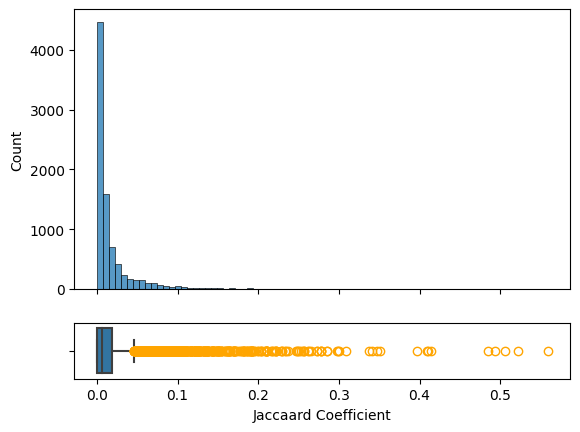

In [8]:
# Create grid layout
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])

# Histogram
ax0 = plt.subplot(gs[0])
sns.histplot(res_df["Jaccard_Coefficient"], ax=ax0, kde=False, bins = 75)
ax0.set(xlabel="")
# turn off x tick labels
ax0.set_xticklabels([])

# Boxplot
ax1 = plt.subplot(gs[1])
sns.boxplot(
    x=res_df["Jaccard_Coefficient"], ax=ax1,
    flierprops=dict(marker="o", markeredgecolor="orange", markerfacecolor="none", markersize=6),
)
ax1.set(xlabel="Jaccaard Coefficient")

# Display the plot
plt.show()

In [9]:
# display the cutoff
def calculate_1_5_iqr_thresholds(numbers):
    Q1 = np.percentile(numbers, 25)
    Q3 = np.percentile(numbers, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

print("1.5 IQR upper bound cutoff for Jaccard Coefficient:", calculate_1_5_iqr_thresholds(res_df["Jaccard_Coefficient"])[1])

1.5 IQR upper bound cutoff for Jaccard Coefficient: 0.046


## Calculate cluster connections
produces a csv file `[for_Cytoscape]cluster_connectivity.csv` to visualize as a graph in Cytoscape
the csv files contains the following columns:
- cluster1: source cluster
- cluster2: target cluster
- percent_possible_connections: percent of possible connections between the two clusters



In [10]:
# get the list of clusters
list_of_clusters = sorted(adata.obs[annotation_to_use].unique().tolist())

label_total_counts = dict(Counter(annot_df[annotation_to_use]))

# for every possible pairs of clusters, compute the connectivity
with open(output_dir / f"[for_Cytoscape]cluster_connectivity.csv", "w") as f:
    f.write("cluster1,cluster2,percent_possible_connections\n")
    for combo in tqdm(list(combinations(list_of_clusters, 2))):
        c1 = combo[0]
        c2 = combo[1]
        c1toc2, c2toc1 = clusterwise_connection(
            annot_df, res_df,
            annot_col_name=annotation_to_use, gene_name_col=id_name,
            cluster1_name=c1, cluster2_name=c2,
            normalize_conn=False,
            restrict_to_interfacial=False,
            interfacial_proteins=None,
        )

        # this line computes the percentage of possible connections
        perc_total_conn = (c1toc2 / (label_total_counts[c1] * 20) + c2toc1 / (label_total_counts[c2] * 20)) / 2
        # print(f"{c1toc2}\t{c2toc1}")
        f.write(f"{c1},{c2},{perc_total_conn}\n")

  0%|          | 0/210 [00:00<?, ?it/s]